In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score


In [3]:
df_train=pd.read_csv("Corona_NLP_train.csv",encoding="latin-1")

In [4]:
df_test=pd.read_csv("Corona_NLP_test.csv")

In [5]:
df_train.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [6]:
df_test.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


In [7]:
df_train.nunique()


UserName         41157
ScreenName       41157
Location         12220
TweetAt             30
OriginalTweet    41157
Sentiment            5
dtype: int64

In [8]:
df_train.isna().sum()


UserName            0
ScreenName          0
Location         8590
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

In [9]:
len(df_train)


41157

In [10]:
import re
df_train["OriginalTweet"].str.lower()
df_train['OriginalTweet'] = df_train['OriginalTweet'].apply(lambda x: re.sub(r'http\S+', '', x))
import string
df_train['OriginalTweet'] = df_train['OriginalTweet'].str.translate(str.maketrans('', '', string.punctuation))
df_train['OriginalTweet'] = df_train['OriginalTweet'].str.replace('\d+', '')
df_train['OriginalTweet'] = df_train['OriginalTweet'].str.strip()
df_train['OriginalTweet'] = df_train['OriginalTweet'].apply(lambda x: ' '.join(x.split()))

C:\Users\himanshu\AppData\Local\Temp\ipykernel_26380\2820254018.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  df_train['OriginalTweet'] = df_train['OriginalTweet'].str.replace('\d+', '')


In [11]:
import re
df_test["OriginalTweet"].str.lower()
df_test['OriginalTweet'] = df_test['OriginalTweet'].apply(lambda x: re.sub(r'http\S+', '', x))
import string
df_test['OriginalTweet'] = df_test['OriginalTweet'].str.translate(str.maketrans('', '', string.punctuation))
df_test['OriginalTweet'] = df_test['OriginalTweet'].str.replace('\d+', '')
df_test['OriginalTweet'] = df_test['OriginalTweet'].str.strip()
df_test['OriginalTweet'] = df_test['OriginalTweet'].apply(lambda x: ' '.join(x.split()))


C:\Users\himanshu\AppData\Local\Temp\ipykernel_26380\3294693085.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  df_test['OriginalTweet'] = df_test['OriginalTweet'].str.replace('\d+', '')


In [12]:
from tensorflow.keras.preprocessing.text import Tokenizer


In [13]:
tokenizer=Tokenizer(num_words=10000,oov_token="<OOV>")


In [14]:
tokenizer.fit_on_texts(df_train["OriginalTweet"])


In [15]:
word_index=tokenizer.word_index
print(len(word_index))


59952


In [16]:
sequences=tokenizer.texts_to_sequences(df_train["OriginalTweet"])


In [17]:
print(len(sequences))


41157


In [18]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

padded = pad_sequences(sequences,padding="post",maxlen=100,truncating="post")
print(padded)

[[   1    1    1 ...    0    0    0]
 [ 504  892    3 ...    0    0    0]
 [   9  798 1803 ...    0    0    0]
 ...
 [  14  127  202 ...    0    0    0]
 [  11   29  722 ...    0    0    0]
 [   1  191    1 ...    0    0    0]]


In [19]:
len(padded[0])


100

In [20]:
test_sequences=tokenizer.texts_to_sequences(df_test["OriginalTweet"])


In [21]:
len(test_sequences)


3798

In [22]:
test_padded = pad_sequences(test_sequences,padding="post",maxlen=100,truncating="post")
print(test_padded)

[[2192   91 5743 ...    0    0    0]
 [  73   15 1975 ...    0    0    0]
 [ 203   42   52 ...    0    0    0]
 ...
 [   1 5063    6 ...    0    0    0]
 [ 972   61    3 ...    0    0    0]
 [  15    4    1 ...    0    0    0]]


In [23]:
import tensorflow as tf


In [24]:
# Create a MirroredStrategy.
strategy = tf.distribute.MirroredStrategy()

print('Number of devices: {}'.format(strategy.num_replicas_in_sync))
from tensorflow.keras.regularizers import l1, l2, l1_l2

# Open a strategy scope.
with strategy.scope():
    # Define a model using the Sequential API
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(10000, 16, input_length=100),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(150)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(5, activation='softmax', kernel_regularizer=l1_l2(l1=0.01, l2=0.01))
    ])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Number of devices: 1


In [25]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 16)           160000    
                                                                 
 bidirectional (Bidirectiona  (None, 300)              200400    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 300)               0         
                                                                 
 dense (Dense)               (None, 5)                 1505      
                                                                 
Total params: 361,905
Trainable params: 361,905
Non-trainable params: 0
_________________________________________________________________


In [26]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df_train["Sentiment"]=le.fit_transform(df_train["Sentiment"])

labels=tf.keras.utils.to_categorical(df_train["Sentiment"],num_classes=5)

df_test["Sentiment"]=le.fit_transform(df_test["Sentiment"])

test_labels=tf.keras.utils.to_categorical(df_test["Sentiment"],num_classes=5)

In [27]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)


In [28]:
num_epochs = 30
history = model.fit(padded, labels, epochs=num_epochs,validation_data=(test_padded, test_labels), verbose=1,callbacks=[early_stop])


Epoch 1/30
1287/1287 [==============================] - 277s 212ms/step - loss: 1.6363 - accuracy: 0.2748 - val_loss: 1.5985 - val_accuracy: 0.2493
Epoch 2/30
1287/1287 [==============================] - 277s 216ms/step - loss: 1.5301 - accuracy: 0.3136 - val_loss: 1.4275 - val_accuracy: 0.3423
Epoch 3/30
1287/1287 [==============================] - 305s 237ms/step - loss: 1.3019 - accuracy: 0.4866 - val_loss: 1.2264 - val_accuracy: 0.5674
Epoch 4/30
1287/1287 [==============================] - 298s 231ms/step - loss: 1.0923 - accuracy: 0.6413 - val_loss: 1.1068 - val_accuracy: 0.6422
Epoch 5/30
1287/1287 [==============================] - 288s 224ms/step - loss: 0.9844 - accuracy: 0.6989 - val_loss: 1.0505 - val_accuracy: 0.6701
Epoch 6/30
1287/1287 [==============================] - 282s 219ms/step - loss: 0.9135 - accuracy: 0.7367 - val_loss: 1.0054 - val_accuracy: 0.6935
Epoch 7/30
1287/1287 [==============================] - 270s 210ms/step - loss: 0.8680 - accuracy: 0.7610 - val_

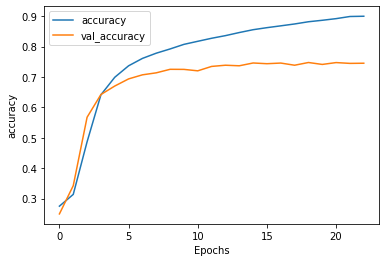

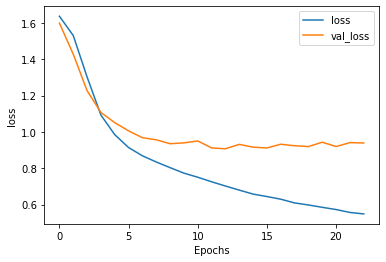

In [29]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")